In [9]:
import easydict
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import linalg
from PIL import Image
from skimage import io, img_as_float, img_as_uint
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import timm

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch import optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

import argparse
import random
import numpy as np
import os

from tqdm import tqdm
from glob import glob

import PIL.Image as Image
import copy

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import pandas as pd
from numpy.linalg import svd
from scipy.special import factorial
import sympy as sp
import copy as cp
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def dk_privacy_l2(ori_img,  epsilon):
    return np.sqrt(np.square(ori_img)).sum(axis = 0)/epsilon

def dk_privacy(ori_img, k, epsilon):
    sampling_1 = 1/2 * np.power(epsilon/np.sqrt(np.pi),k) * factorial(k/2-1)/factorial(k-1) * np.exp(-epsilon * np.sqrt(np.square(ori_img)).sum(axis = 0))
    while True:
        derivative = dk_privacy_l2(sampling_1, epsilon)
        sampling_1 -= derivative
        if derivative <= 1e-10:
            break
    return sampling_1

def getRandomSamplesOnNSphere(N , R , numberOfSamples):
    # Return 'numberOfSamples' samples of vectors of dimension N 
    # with an uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    X = np.random.default_rng().normal(size=(numberOfSamples , N))

    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

def trans_privacy(ori_img, k, epsilon):
    ind = np.argpartition(ori_img, -k)[-k:]
    top_k = ori_img[ind]
    trans_vec = dk_privacy(top_k, k, epsilon)
    radial = getRandomSamplesOnNSphere(k, trans_vec, 1)
    result_vec = top_k +  radial * trans_vec
    trans_img = np.zeros_like(ori_img)
    trans_img[ind] = result_vec
    return trans_img

def img_svd(img, k, epsilon):
    red, green, blue = cp.deepcopy(img[:,:,0]), cp.deepcopy(img[:,:,1]), cp.deepcopy(img[:,:,2])

    U_red, S_red, V_red = svd(red, full_matrices = False)
    U_green, S_green, V_green  = svd(green, full_matrices = False)
    U_blue, S_blue, V_blue = svd(blue, full_matrices = False)

    trans_red = trans_privacy(S_red, k, epsilon)
    trans_green = trans_privacy(S_green, k, epsilon)
    trans_blue = trans_privacy(S_blue, k, epsilon)

    final_red = U_red @ (np.diag(trans_red) @ V_red)
    final_green = U_green @ (np.diag(trans_green) @ V_green)
    final_blue = U_blue @ (np.diag(trans_blue) @ V_blue)


    fimg = np.zeros(img.shape)

    fimg[:,:,0], fimg[:,:,1], fimg[:,:,2] = final_red, final_green, final_blue

    for i in range(len(fimg)):
        for j in range(len(fimg[i])):
            for w in range(len(fimg[i][j])):
                fimg[i,j,w] = min(255, abs(fimg[i,j,w]))

    fimg = fimg.astype(np.uint8)
    return fimg

def dp_svd(images, k, epsilon):
    noisy_images = img_svd(images, k, epsilon)
#     display_image_grid(noisy_images)
    return noisy_images

def pillow_to_numpy(I):
    img = np.asarray(I, dtype=np.float32)
    return img


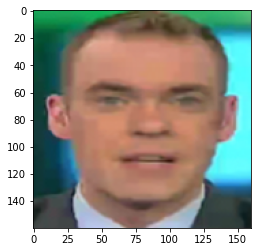

In [16]:

# 원래 k=7, epsilon = 0.01
k = 50
epsilon= 0.01
image = Image.open('/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/test/fake/875_979/0000.png')

# b = pillow_to_numpy(image)
# svd_img = dp_svd(b,k,epsilon)
# svd_img = svd_img.astype('uint8')
# plt.imshow(svd_img)
k_list = [1,3,5,7,15,30]
for i in k_list:
    a = pillow_to_numpy(image)
    dpimg = dp_svd(a,i,epsilon)
    dpimg = dpimg.astype('uint8')
#     cv2.imwrite('./kaia_figure/pix_eps_{}.png'.format(i), cv2.cvtColor(dpimg,cv2.COLOR_RGB2BGR))
    cv2.imwrite('./kaia_figure/svd/svd_epsilon_{}.png'.format(i), cv2.cvtColor(dpimg,cv2.COLOR_RGB2BGR))
plt.imshow(dpimg)

dpimg = dp_svd(a, k, epsilon)
dpimg = dpimg.astype('uint8')
plt.imshow(dpimg)

### valid dataset generation

In [ ]:
# import os
# df_imgdir = glob('/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/val/real/*/')
# fake_img_dir = '/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/val/real/'

# k = 7
# epsilon = 0.01

# for idx, folder in enumerate(df_imgdir):
    
#     # extract the last part of the folder for joining path
#     imgfolder = folder.split('/')[-2]
#     if not os.path.exists('/home/data/privacy/svd/val/real/{0}'.format(imgfolder)):
#         os.makedirs(os.path.join('/home/data/privacy/svd/val/real/', imgfolder))
#     subfolder = os.path.join('/home/data/privacy/svd/val/real/', imgfolder)
    
#     # subfolder = location of saved area
#     # globfolder = location of train data
#     globfolder = fake_img_dir + imgfolder + '/*'
    
#     print(globfolder, 'glob folder')
# #     print(subfolder)
#     # generating pixelation image per every image of each subfolder
#     for idx2, img in enumerate(glob(globfolder)):
#         image = Image.open(img)
#         a = pillow_to_numpy(image)
#         dpimg = dp_svd(a, k, epsilon)

    
#         dpimg = dpimg.astype('uint8')
    
#         plt.imshow(dpimg)
#         cv2.imwrite(subfolder+'/folder_{0}_val_real_svd{1}.jpg'.format(idx, idx2),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
#         if idx2 == 10:
#             print(subfolder, 'sub folder')
            
# print('######finished validation svd!!##########')

# ##############################################################################################################################

125
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/978/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/978 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/878/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/878 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/992/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/992 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/902/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/902 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/961/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/961 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/934/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/934 sub f

/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/910 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/933/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/933 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/986/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/986 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/907/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/907 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/895/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/895 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/920/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/920 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/922/* glob folde

/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/995/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/995 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/876/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/876 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/915/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/915 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/974/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/974 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/938/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/938 sub folder
/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/941/* glob folder
/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/941 sub folde

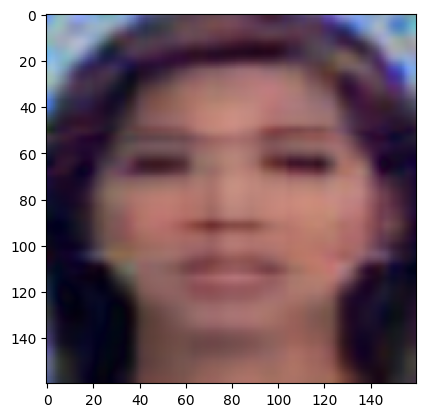

In [14]:
import os
df_imgdir = glob('/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/*/')
fake_img_dir = '/home/data/deepfake_privacy/FF_original/FaceForensics++/DeepFake/test/real/'
k = 7
epsilon = 0.01

print(len(df_imgdir))
for idx, folder in enumerate(df_imgdir):
    
    # extract the last part of the folder for joining path
    imgfolder = folder.split('/')[-2]
    if not os.path.exists('/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/{0}'.format(imgfolder)):
        os.makedirs(os.path.join('/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/', imgfolder))
    subfolder = os.path.join('/home/data/deepfake_privacy/ff_priv/DeepFake/svd/test/real/', imgfolder)
    
    # subfolder = location of saved area
    # globfolder = location of train data
    globfolder = fake_img_dir + imgfolder + '/*'
    
    print(globfolder, 'glob folder')

    # generating pixelation image per every image of each subfolder
    for idx2, img in enumerate(glob(globfolder)):
        image = Image.open(img)
        a = pillow_to_numpy(image)
        dpimg = dp_svd(a, k, epsilon)
    
        dpimg = dpimg.astype('uint8')
    
        plt.imshow(dpimg)
        cv2.imwrite(subfolder+'/folder_{0}_real_svd{1}.jpg'.format(idx, idx2),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
        if idx2 == 10:
            print(subfolder, 'sub folder')
            
print('######finished svd!!##########')

##############################################################################################################################

### Applying svd to DF images (w/0 facemask)

In [ ]:
from glob import glob

# k 값과 epsilon 값 조절해서 deepfake에 svd 적용.

k = 7
epsilon = 0.01

df_imgdir = glob('/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/test/real/*/*')

for idx, img in enumerate(df_imgdir):
    image = Image.open(img)
    a = pillow_to_numpy(image)
    dpimg = dp_svd(a, k, epsilon)
    dpimg = dpimg.astype('uint8')


    # folder경로 지정해줘서 이미지 생성 
    cv2.imwrite('./df_svd/df_orig_svd/real/df_real_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
    
print('done saving real svd files')   

df_fakeimgdir = glob('/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/test/fake/*/*')

for idx, img in enumerate(df_fakeimgdir):
    image = Image.open(img)
    a = pillow_to_numpy(image)
    dpimg = dp_svd(a, k, epsilon)
    dpimg = dpimg.astype('uint8')
    
    # folder 경로 지정해줘서 이미지 생성
    cv2.imwrite('./df_svd/df_orig_svd/fake/df_fake_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))

print('done saving fake svd files')
    

In [ ]:
from glob import glob

k = 7
epsilon = 0.01

fake_mask_dir = glob('/media/data1/donggeun/masked_test/FaceForensics++/DeepFake/fake/*/*')
real_mask_dir = glob('/media/data1/donggeun/masked_test/FaceForensics++/DeepFake/real/*/*')

for idx, img in enumerate(fake_mask_dir):
    image = Image.open(img)
    fake_mask = pillow_to_numpy(image)
    dpimg = dp_svd(fake_mask, k, epsilon)
    
    dpimg = dpimg.astype('uint8')
    
    plt.imshow(dpimg)
    cv2.imwrite('./df_svd/df_mask_svd/fake/df_mask_fake_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))

print('Done saving fake mask svd images')
    
for idx, img in enumerate(real_mask_dir):
    image = Image.open(img)
    real_mask = pillow_to_numpy(image)
    dpimg = dp_svd(real_mask, k, epsilon)
    
    dpimg = dpimg.astype('uint8')
    
    plt.imshow(dpimg)
    cv2.imwrite('./df_svd/df_mask_svd/real/df_mask_real_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
    
print('Done saving real mask svd images')


In [ ]:
from glob import glob

k = 7
epsilon = 0.01

df_imgdir = glob('/media/data1/donggeun/FF_original/FaceForensics++/DeepFake/test/real/*/*')

for idx, img in enumerate(df_imgdir):
    image = Image.open(img)
    a = pillow_to_numpy(image)
    dpimg = dp_svd(a, k, epsilon)
    dpimg = dpimg.astype('uint8')
    
    plt.imshow(dpimg)
    cv2.imwrite('./df_svd/df_orig_svd/real/df_real_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
    
print('done saving real svd files')   

In [ ]:
### svd for real ppl with mask -> svd


real_mask_dir = glob('/media/data1/donggeun/masked_test/FaceForensics++/DeepFake/real/*/*')


for idx, img in enumerate(real_mask_dir):
    image = Image.open(img)
    real_mask = pillow_to_numpy(image)
    dpimg = dp_svd(real_mask, k, epsilon)
    
    dpimg = dpimg.astype('uint8')
    
    plt.imshow(dpimg)
    cv2.imwrite('./df_svd/df_mask_svd/real/df_mask_real_svd_{}.jpg'.format(idx),cv2.cvtColor(dpimg, cv2.COLOR_RGB2BGR))
    
print('Done saving real mask svd images')